In [1]:
# !pip install torch_geometric

In [2]:
from torch_geometric.datasets import QM9
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d, Dropout, LayerNorm
from torch_geometric.utils import to_networkx
from torch_geometric.loader import DataLoader
import torch
from random import randint
from torch.nn import TransformerEncoderLayer, TransformerEncoder

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cpu')

In [5]:
dataset = QM9(root="./dataset/")

In [6]:
data = dataset.data
print(data)
print(dataset.num_features)
print(dataset.num_classes)
print(len(dataset))

Data(x=[2359210, 11], edge_index=[2, 4883516], edge_attr=[4883516, 4], y=[130831, 19], pos=[2359210, 3], idx=[130831], name=[130831], z=[2359210])
11
19
130831


D:\GNN\.venv\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [7]:
# dataset.print_summary()
target = 6 # Setting zero point vibrational energy as the target variable.
dataset.data.y = dataset.data.y[:, target]
dataset.data.y = (dataset.data.y - dataset.data.y.mean()) / dataset.data.y.std()
# dataset.x = (dataset.x - dataset.x.mean(dim=0)) / dataset.x.std(dim=0)

D:\GNN\.venv\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [8]:
dataset.x[0]

tensor([0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 4.])

In [9]:
dataset.y[0]

tensor(-3.1487)

In [10]:
dataset.num_classes

D:\GNN\.venv\Lib\site-packages\torch_geometric\data\dataset.py:169: UserWarning: Found floating-point labels while calling `dataset.num_classes`. Returning the number of unique elements. Please make sure that this is expected before proceeding.
  warnings.warn("Found floating-point labels while calling "


72452

In [11]:
def plot_graph(graph_data):
    graph = to_networkx(graph_data, to_undirected=True)

    def visualize_graph(G):
        plt.figure(figsize=(7,7))
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=True)
        plt.show()

    visualize_graph(graph)

torch.Size([19, 11])
torch.Size([1])


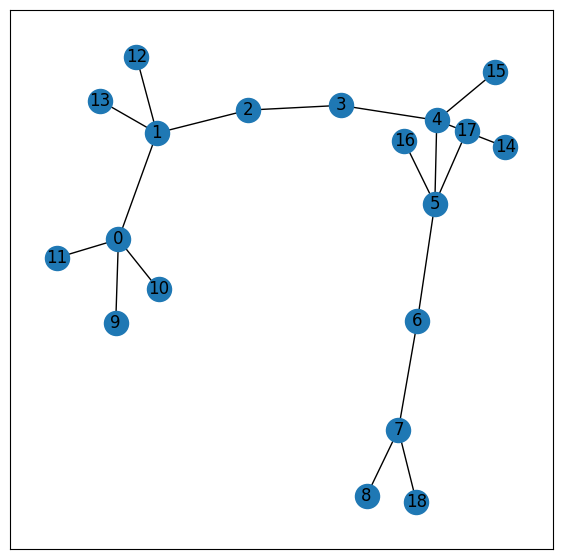

torch.Size([20, 11])
torch.Size([1])


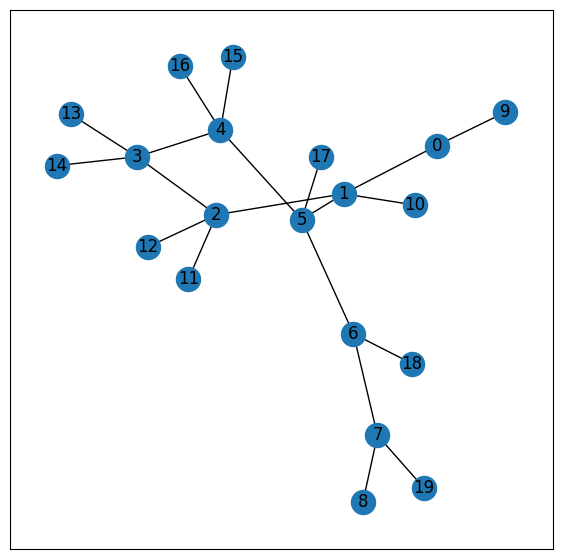

torch.Size([14, 11])
torch.Size([1])


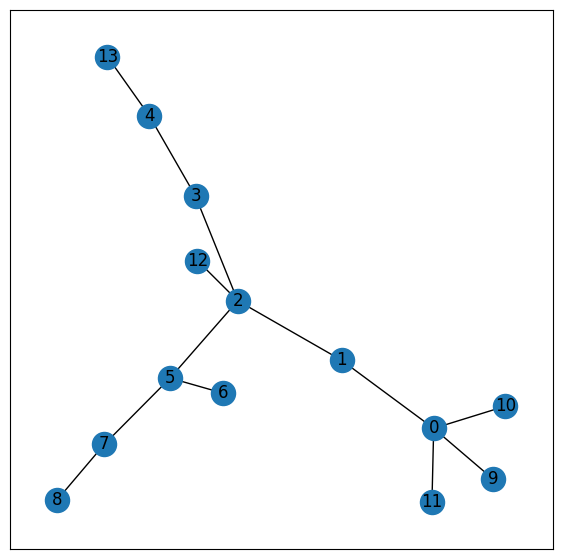

torch.Size([16, 11])
torch.Size([1])


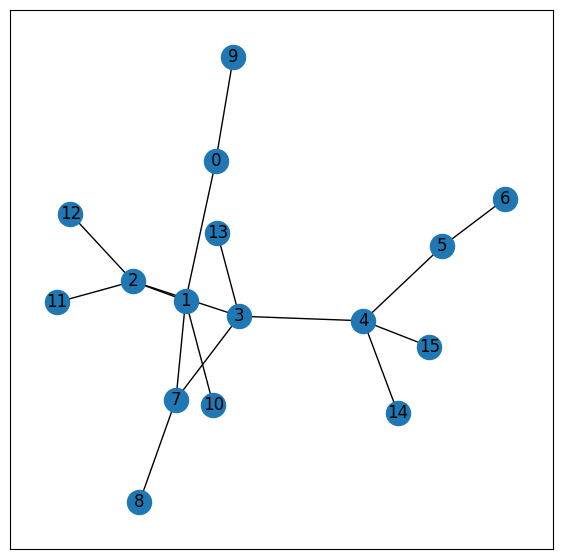

torch.Size([14, 11])
torch.Size([1])


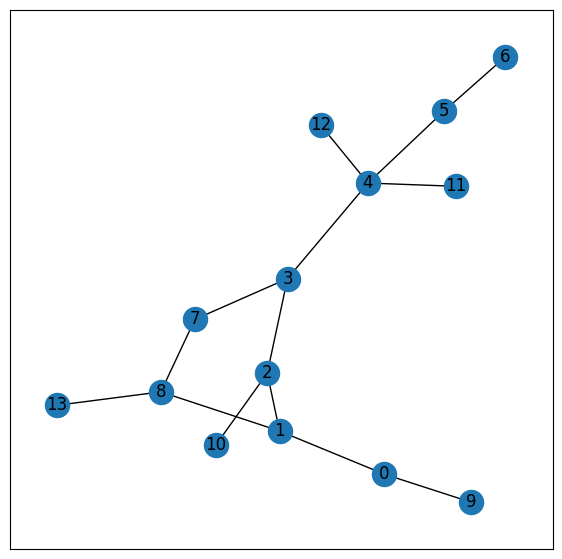

In [12]:
for _ in range(0, 5):
    idx = randint(0, len(dataset) - 1)
    data = dataset[idx]
    print(data.x.shape)
    print(data.y.shape)
    plot_graph(data)

In [22]:
class SymbolicReasoner(torch.nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim

        # Symbolic rule encoder
        self.rule_encoder = torch.nn.Sequential(
            Linear(hidden_dim, hidden_dim),
            LayerNorm(hidden_dim),
            torch.nn.ReLU(),
            Dropout(0.2)
        )

        # Rule application mechanism
        self.rule_applicator = torch.nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=4,
            dropout=0.2,
            batch_first=True
        )

    def forward(self, x, rules):
        # Encode symbolic rules
        encoded_rules = self.rule_encoder(rules)

        # Apply rules through attention mechanism
        enhanced_features, _ = self.rule_applicator(
            query=x,
            key=encoded_rules,
            value=encoded_rules
        )

        return enhanced_features + x  # Residual connection

class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_dim=128, num_heads=4):
        super().__init__()

        self.gnn1 = GCNConv(num_node_features, hidden_dim)
        self.gnn2 = GCNConv(hidden_dim, hidden_dim)

        # Symbolic Reasoning Component
        self.symbolic_reasoner = SymbolicReasoner(hidden_dim)

        # Transformer Component
        encoder_layer = TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim*4,
            batch_first=True
        )
        self.transformer = TransformerEncoder(encoder_layer, num_layers=3)

        # Output layers
        self.linear1 = Linear(hidden_dim, hidden_dim)
        self.linear2 = Linear(hidden_dim, 1)

        # Normalization and Dropout
        self.norm1 = LayerNorm(hidden_dim)
        self.norm2 = LayerNorm(hidden_dim)
        self.dropout = Dropout(0.2)

        # Initialize symbolic rules (learnable)
        self.num_rules = 5  # Number of symbolic rules
        self.symbolic_rules = torch.nn.Parameter(
            torch.randn(self.num_rules, hidden_dim)
        )

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # GNN Processing
        x = self.gnn1(x, edge_index)
        x = F.relu(x)
        x = self.norm1(x)
        x = self.dropout(x)

        x = self.gnn2(x, edge_index)
        x = F.relu(x)
        x = self.norm2(x)
        x = self.dropout(x)

        # Apply symbolic reasoning
        x = self.symbolic_reasoner(x, self.symbolic_rules)

        # Prepare for Transformer
        max_nodes = max(torch.bincount(batch))
        batch_size = batch[-1].item() + 1

        x_padded = torch.zeros(batch_size, max_nodes, x.size(-1), device=x.device)
        for i in range(batch_size):
            batch_mask = (batch == i)
            x_padded[i, :batch_mask.sum()] = x[batch_mask]

        # Transformer Processing
        x = self.transformer(x_padded)

        # Global pooling
        x = x.mean(dim=1)

        # Final prediction
        x = self.linear1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)

        return x

class CurriculumLearning(torch.nn.Module):
    
    def __init__(self, model, train_loader, val_loader, test_loader, optimizer, scheduler, criterion, device, *args,
                 **kwargs):
        
        super().__init__(*args, **kwargs)
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.criterion = criterion
        self.device = device
        self.difficulty_levels = 3
        self.current_level = 0
        self.level_epochs = 20
        self.promotion_threshold = 0.2

    def get_difficulty_mask(self, batch):
        # Calculate molecular complexity (example metric)
        complexity = torch.tensor([data.num_nodes for data in batch.to_data_list()])

        # Define difficulty thresholds based on current level
        if self.current_level == 0:
            return complexity <= complexity.median()
        elif self.current_level == 1:
            return (complexity > complexity.median()) & (complexity <= complexity.quantile(0.8))
        else:
            return complexity > complexity.quantile(0.8)

    def train_epoch(self, epoch):
        self.model.train()
        total_loss = 0

        for batch in self.train_loader:
            batch = batch.to(self.device)

            diff_mask = self.get_difficulty_mask(batch)
            if not diff_mask.any():
                continue

            self.optimizer.zero_grad()

            out = self.model(batch)
            loss = self.criterion(out.squeeze()[diff_mask], batch.y[diff_mask])

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()

            total_loss += loss.item()

        # Update curriculum level
        if (epoch + 1) % self.level_epochs == 0:
            val_loss = self.validate()
            if val_loss < self.promotion_threshold and self.current_level < self.difficulty_levels - 1:
                self.current_level += 1
                print(f"Promoted to difficulty level {self.current_level}")

        return total_loss / len(self.train_loader)

    def validate(self):
        self.model.eval()
        total_loss = 0

        with torch.no_grad():
            for batch in self.val_loader:
                batch = batch.to(self.device)
                out = self.model(batch)
                loss = self.criterion(out.squeeze(), batch.y)
                total_loss += loss.item()

        avg_loss = total_loss / len(self.val_loader)
        self.scheduler.step(avg_loss)
        return avg_loss

    def test(self):
        self.model.eval()
        total_loss = 0

        with torch.no_grad():
            for batch in self.test_loader:
                batch = batch.to(self.device)
                out = self.model(batch)
                loss = self.criterion(out.squeeze(), batch.y)
                total_loss += loss.item()

        return total_loss / len(self.test_loader)

In [23]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))

train_dataset = dataset[:train_size]
val_dataset = dataset[train_size:train_size+val_size]
test_dataset = dataset[train_size+val_size:]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [15]:
train_losses = []
val_losses = []
test_losses = []

In [16]:
def plot_losses():
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    # plt.plot(test_losses, label="Testing Loss")
    plt.legend()
    plt.show()

In [17]:
# @torch.no_grad()
# def validate(model, criterion, scheduler):
#     gcn.eval()
#     val_loss = 0
#     with torch.no_grad():
#         for batch in val_loader:
#             batch = batch.to(device)
#             out = model(batch)
#             val_loss += criterion(out.squeeze(), batch.y).item()

#     val_loss /= len(val_loader)
#     val_losses.append(val_loss)
#     scheduler.step(val_loss)

#     return val_loss / len(val_loader)

In [18]:
# def train(model, optimizer, criterion, scheduler, epoch):
#     gcn.train()
#     total_loss = 0
#     for batch in train_loader:
#         batch = batch.to(device)
#         optimizer.zero_grad()

#         out = gcn(batch)
#         loss = criterion(out.squeeze(), batch.y)

#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(gcn.parameters(), max_norm=1.0)
#         optimizer.step()

#         total_loss += loss.item()

#     avg_loss = total_loss / len(train_loader)
#     test_losses.append(avg_loss)
#     val_loss = validate(model, criterion, scheduler)

#     print(f'Epoch {epoch}: Train Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}')

#     return avg_loss, val_loss

In [19]:
# @torch.no_grad()
# def test(model, criterion):
#     model.eval()
#     total_loss = 0
#     for batch in test_loader:
#         batch = batch.to(device)
#         prediction = model(batch)
#         loss = criterion(prediction, batch.y)
#         total_loss += loss.item()

#     print(f"Test Loss: {total_loss / len(test_loader)}")

In [24]:
model = GCN(num_node_features=dataset.num_features, hidden_dim=128, num_heads=4).to(device)

In [25]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
criterion = torch.nn.MSELoss()
trainer = CurriculumLearning(model, train_loader, val_loader, test_loader, optimizer, scheduler, criterion, device)

In [ ]:
for epoch in range(100):
    train_loss = trainer.train_epoch(epoch)
    val_loss = trainer.validate()
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

test_loss = trainer.test()
print(f"Test Loss: {test_loss}")

Epoch 0: Train Loss: 0.0964, Val Loss: 2.3575


In [ ]:
plot_losses()